In [58]:
#for web scraping and creating dataframe
import requests
from bs4 import BeautifulSoup
import pandas as pd
#to crete model from above web scrapped dataframe
from sklearn.feature_extraction.text import TfidfVectorizer 
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, confusion_matrix, accuracy_score,f1_score
import re
#for visualisation
import seaborn as sns
import matplotlib.pyplot as plt
import os

In [59]:
#to extract data from url using beautifulsoap
def scrape_page(url, title_selector, slug_selector):
    response = requests.get(url)
    if response.status_code == 200:
        soup = BeautifulSoup(response.content, 'html.parser')
        slug_elements = soup.select(slug_selector)
        title_elements = soup.select(title_selector)
        slug_text = [element.get_text(strip=True) for element in slug_elements]
        title_text = [element.get_text(strip=True) for element in title_elements]
        return soup, slug_text, title_text
    else:
        print(f"Failed to fetch data. Status code: {response.status_code}")
        return None, [], []

In [16]:
#collects 100 articles from webpage
def scrape_until_100(url, title_selector, slug_selector):
    all_slug_text = []
    all_title_text = []
    soup, slug_text, title_text = scrape_page(url, title_selector, slug_selector)

    while len(all_slug_text) < 100 and soup:
        all_slug_text.extend(slug_text)
        all_title_text.extend(title_text)

        load_more_button = soup.select_one('.options__load-more')
        if load_more_button:
            url = "https://www.npr.org/sections/news/"
            payload = {'page': len(all_slug_text) // 10 + 1}
            soup, slug_text, title_text = scrape_page(url, title_selector, slug_selector)
        else:
            break

    return all_slug_text[:100], all_title_text[:100]

In [17]:
#website url
initial_url = "https://www.npr.org/sections/news/" 

In [20]:
#selecting article and sector for dataframe or dataset
title_selector = 'div h2.title a'
slug_selector = 'div h3.slug'

In [21]:
# Scraping and creating dataframe
slug_text, title_text = scrape_until_100(initial_url, title_selector, slug_selector)

df_data = pd.DataFrame({'sections': slug_text, 'news': title_text})

In [34]:
#path to store scrapped data
folder_path = 'scrapped_data'

In [27]:
#create folder if not exist
os.makedirs(folder_path, exist_ok=True)

In [35]:
#save data to csv inside foler
csv_file_path = os.path.join('scrapped_data', 'scr_data.csv')
df_data.head(100).to_csv('scr_data.csv', index=False)

In [38]:
#display 100 rows 
print(df_data.head(100))

                          sections  \
0   Middle East crisis — explained   
1                         National   
2                         Politics   
3                  Got A News Tip?   
4        Main Character of the Day   
..                             ...   
95       Main Character of the Day   
96  Middle East crisis — explained   
97                        National   
98                        Politics   
99                 Got A News Tip?   

                                                 news  
0   Qatar says Israel and Hamas agree to a cease-f...  
1   Border Patrol sending migrants to unofficial c...  
2   Trump, 77, issues letter lauding his health an...  
3                     Pope Francis: Climate activist?  
4   CZ, founder of crypto giant Binance, pleads gu...  
..                                                ...  
95  Why a single 'Inverted Jenny' stamp sold for $...  
96  Qatar says Israel and Hamas agree to a cease-f...  
97  Border Patrol sending migrants to u

In [39]:
#checking news column and perform basic preprocessing operation cleaning
if 'news' in df_data.columns:
    def clean_text(text):
        text = re.sub(r'[^A-Za-z0-9]', ' ', text)  
        text = re.sub(r'\s+', ' ', text).strip()
        text = re.sub('\s+',' ',text)  
        return text

In [41]:
#apply cleaning on news column which are feature of our model
df_data['news'] = df_data['news'].apply(clean_text)

In [43]:
#vectorizing data and defining features in X
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(df_data['news'])

In [44]:
#defining labels
y = df_data['sections'] 

In [45]:
#splitting data for training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

In [46]:
#applying classification based model
model = LogisticRegression()
model.fit(X_train, y_train)

LogisticRegression()

In [47]:
#predicting or testing
y_pred = model.predict(X_test)

In [48]:
#calculating performance of model 
accuracy = accuracy_score(y_test, y_pred)
error_rate= 1 - accuracy
print('Accuracy:', accuracy*100)
print('error rate',error_rate*100)

precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
print('Precision:', precision*100)
print('Recall:', recall*100)

Accuracy: 90.0
error rate 9.999999999999998
Precision: 84.28571428571429
Recall: 90.0


In [49]:
#creating confusion matrix
cm = confusion_matrix(y_test, y_pred)

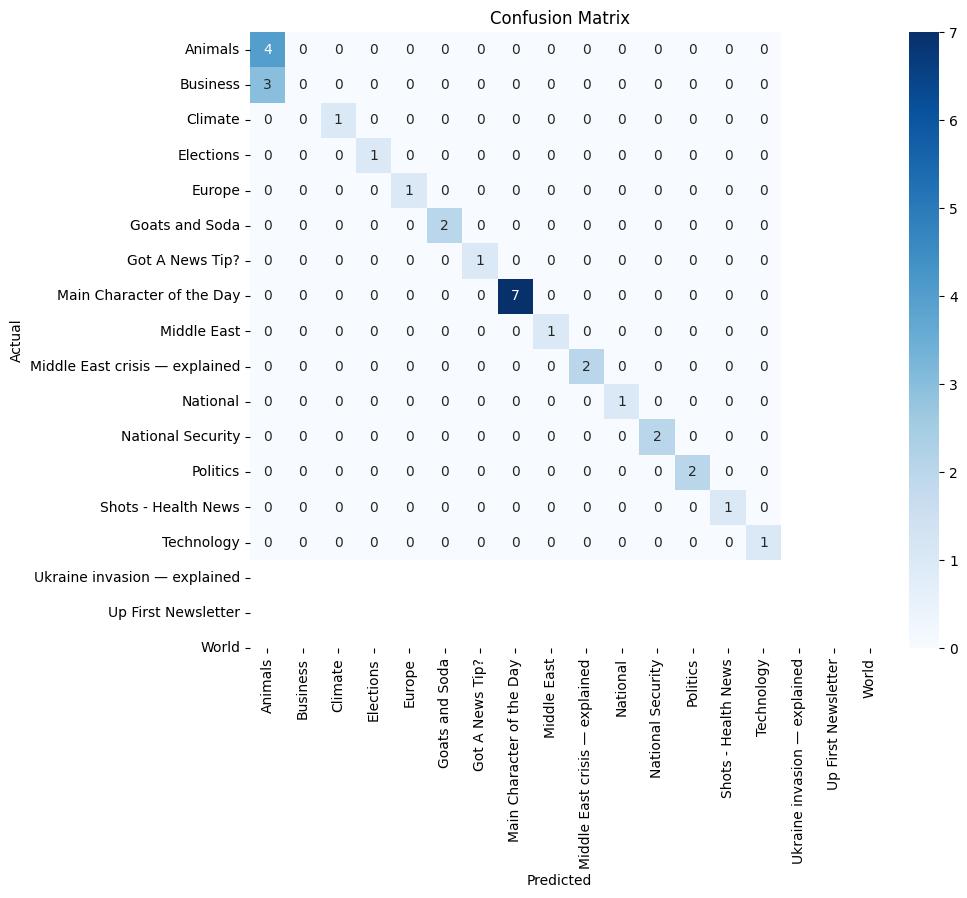

In [51]:
#plotting confusion matrix for our model
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=model.classes_, yticklabels=model.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

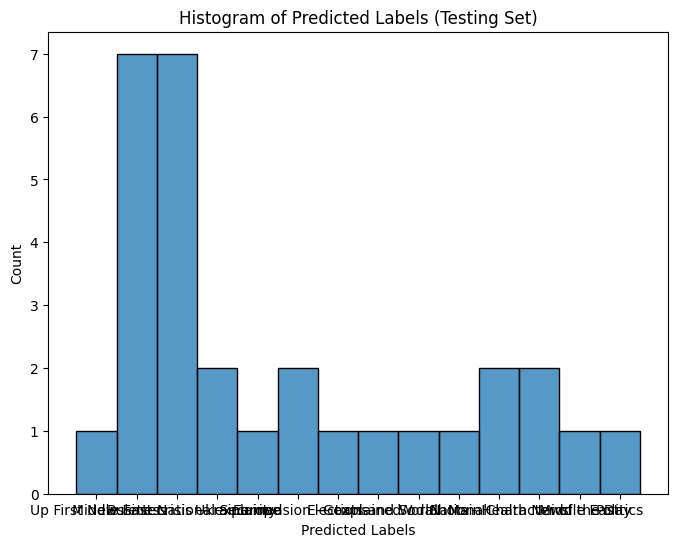

In [53]:
#plotting histogram for predicted labels
plt.figure(figsize=(8, 6))
sns.histplot(y_pred, bins=len(model.classes_), kde=False)
plt.xlabel('Predicted Labels')
plt.ylabel('Count')
plt.title('Histogram of Predicted Labels (Testing Set)')
plt.show()

In [54]:
# Creating dataframe for evolution matrix
evaluation_report = pd.DataFrame({
    'Metric': ['Precision', 'Recall', 'Accuracy', 'Error Rate'],
    'Score': [precision * 100, recall * 100, accuracy * 100, error_rate * 100]
})

In [56]:
#saving report to csv file inside folder
report_file_path = os.path.join('scrapped_data', 'evaluation_report.csv')
evaluation_report.to_csv(report_file_path, index=False)

In [57]:
# Display the evaluation report from dataframe
print("Evaluation Report:")
print(evaluation_report)

Evaluation Report:
       Metric      Score
0   Precision  84.285714
1      Recall  90.000000
2    Accuracy  90.000000
3  Error Rate  10.000000
